<a href="https://colab.research.google.com/github/ann-e888/Neural-Networks---Pytorch-Lightning/blob/main/Introduction_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
pip install -q lightning

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import lightning as L
from lightning.pytorch.tuner import Tuner
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
class BasicLightning(L.LightningModule):
  def __init__(self):

    super().__init__()

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)

  def forward(self, input):

    input_to_top_relu = input * self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu = input * self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
    final_output = F.relu(input_to_final_relu)

    return final_output

In [102]:
input_doses = torch.linspace(start=0, end=1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [103]:
model = BasicLightning()

In [104]:
output_values = model(input_doses)
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

Text(0.5, 0, 'Dose')

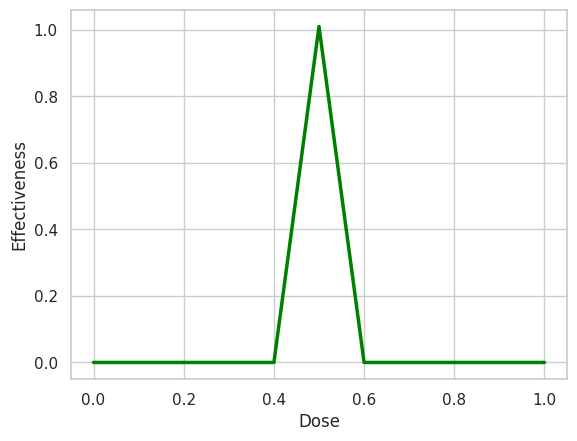

In [105]:
sns.set(style='whitegrid')
sns.lineplot(x=input_doses, y=output_values, color='green', linewidth=2.5)
plt.ylabel('Effectiveness')
plt.xlabel('Dose')

In [111]:
class BasicLightningTrain(L.LightningModule):
  def __init__(self):

    super().__init__()

    self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

    self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
    self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.final_bias = nn.Parameter(torch.tensor(0.), requires_grad=True)

    self.learning_rate = 0.01

  def forward(self, input):

    input_to_top_relu = input * self.w00 + self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output * self.w01

    input_to_bottom_relu = input * self.w10 + self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output * self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
    final_output = F.relu(input_to_final_relu)

    return final_output

  def configure_optimizers(self):
    return optim.SGD(self.parameters(), lr=self.learning_rate)

  def training_step(self, batch, bathc_idx):
    input_i, label_i = batch
    output_i = self.forward(input_i)
    loss = torch.mean((output_i - label_i)**2)
    return loss

In [112]:
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

In [113]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=3)

In [114]:
model = BasicLightningTrain()
trainer = L.Trainer(max_epochs=100
                    #, accelerator='auto', devices='auto', log_every_n_steps=1
                    )
tuner = Tuner(trainer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [115]:
lr_finder = tuner.lr_find(
    model,
    train_dataloaders=dataloader,
    min_lr=0.001,
    max_lr=1.0,
    early_stop_threshold=None
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.11748975549395292
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.11748975549395292
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_109b8cc5-a30d-44b9-9373-e8b3232c603a.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_109b8cc5-a30d-44b9-9373-e8b3232c603a.ckpt


In [116]:
new_lr = lr_finder.suggestion()
print(f'lr_find() suggests {new_lr:.5f} for the learning rate.')

lr_find() suggests 0.11749 for the learning rate.


In [117]:
model.learning_rate = new_lr

In [118]:
trainer.fit(model, train_dataloaders=dataloader)

INFO: 
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [119]:
print(model.final_bias.data)

tensor(-16.0054)


In [120]:
output_values = model(input_doses)

Text(0, 0.5, 'Effectiveness')

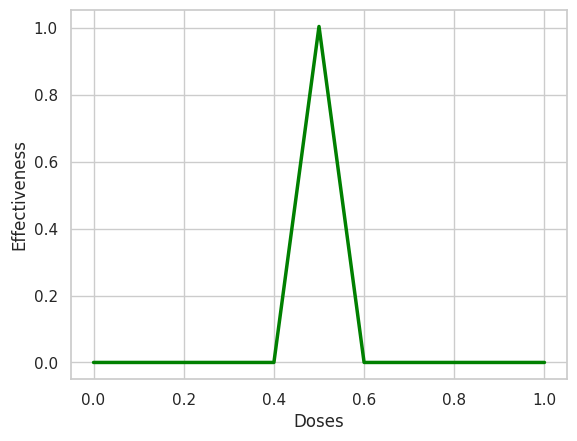

In [121]:
sns.set(style='whitegrid')

sns.lineplot(x=input_doses, y=output_values.detach(), color='green', linewidth=2.5)
plt.xlabel('Doses')
plt.ylabel('Effectiveness')